In [49]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

torch.set_float32_matmul_precision("medium")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [51]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, stratify=img_labels['label'])

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon,path
60673,3670ac8b-fbb0-4c62-a3a6-b41cab0dcdb6,Mapillary,990128028194028,Washington,United States,USA,9923602340269522944,47,38.907748,-77.034491,../data/imgs/9e691fc1-34a4-4660-9a2d-4e91ee242...
72691,fbfcec70-539d-46be-af8f-209eb94f581c,Mapillary,477336763599019,Washington,United States,USA,9923602559312855040,16,38.905262,-77.018941,../data/imgs/e4ee5166-9827-44fc-a9e7-a84bbb8da...
82,ecca3aae-e564-4b4f-a75c-1520c18698d7,Mapillary,1197537960668531,Washington,United States,USA,9923602144848510976,46,38.904194,-77.024098,../data/imgs/ba26ad4e-8895-42ea-a3c7-de3bee6af...
182047,61d94914-bf28-401d-82ec-b2bf0f683572,Mapillary,472187007397475,Washington,United States,USA,9923602138406060032,15,38.899798,-77.026886,../data/imgs/71c20dec-b7b4-4b9d-ace6-1bacd7416...
152322,7c5da120-bcf1-4cc2-9bbb-7e257781dbb7,Mapillary,3338178886394259,Washington,United States,USA,9923602144848510976,46,38.903001,-77.022754,../data/imgs/bac611f9-29f8-4c8f-801a-4541e77ad...


Washington


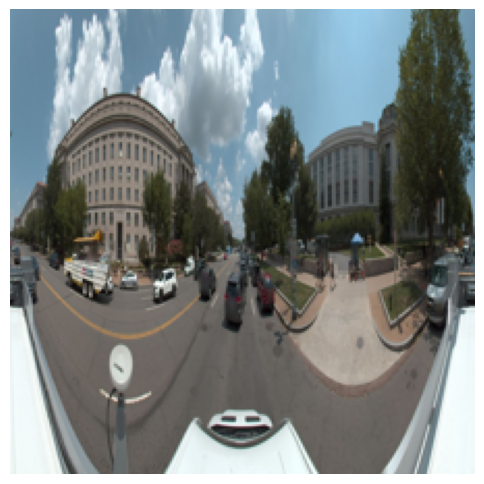

In [52]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [53]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_16_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")

#model = model.to(device=device)
#print(f"Using device: {device}")

Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=59, bias=True)
Number of classes: 59


In [54]:
model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Using device: cuda


In [55]:
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_loss = 0
for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_loss += avg_train_loss
    print(f"Loss: {avg_train_loss:.3f} ({train_loss / (epoch+1):.3f})")
    torch.save(model.state_dict(), f'vit_b_16_base_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 3.863 (3.863)
EPOCH: 2


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 3.440 (3.652)
EPOCH: 3


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 2.934 (3.413)
EPOCH: 4


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 2.527 (3.191)
EPOCH: 5


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 2.208 (2.995)


In [56]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 2.204
Test Accuracy: 39.29%
